# AutoEncoder

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_circles

## 加载训练数据

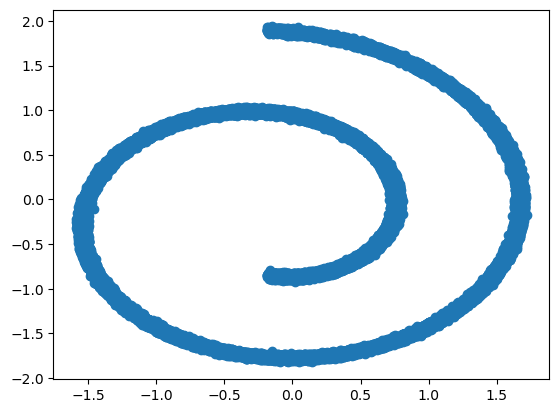

In [2]:
x, _ = make_swiss_roll(n_samples=100_000, noise=0.1)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()

plt.scatter(x[:, 0], x[:, 1])

## 将数据转换为 Torch Tensor

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [4]:
X = torch.tensor(x, dtype=torch.float32)
X.shape

torch.Size([100000, 2])

In [5]:
dataset = TensorDataset(X)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [6]:
for batch_idx, data in enumerate(train_loader):
    print(data[0].shape)
    break

torch.Size([128, 2])


## 定义 AE 模型

In [7]:
class AE(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
        )
     
    def encode(self, x):
        h = self.encoder(x)
        return h
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

## 定义 AE Loss

In [8]:
def ae_loss(recon_x, x):
    # 重构损失
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    
    return recon_loss

## 开始训练

In [9]:
def train(model, train_loader, optimizer, scheduler, epochs, device):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0].to(device)
            optimizer.zero_grad()
            
            # 前向传播
            recon_batch = model(data)
            loss = ae_loss(recon_batch, data)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        # 记录并打印损失
        avg_loss = epoch_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')
    
    return losses

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练模型
epochs = 30
model = AE(input_dim=2, hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.005, total_iters=epochs)
losses = train(model, train_loader, optimizer, scheduler, epochs, device) # beta 对结果影响很大

Epoch 1/30, Loss: 0.031169
Epoch 2/30, Loss: 0.018489
Epoch 3/30, Loss: 0.016782
Epoch 4/30, Loss: 0.016594
Epoch 5/30, Loss: 0.016526
Epoch 6/30, Loss: 0.016067
Epoch 7/30, Loss: 0.016651
Epoch 8/30, Loss: 0.016406
Epoch 9/30, Loss: 0.016310
Epoch 10/30, Loss: 0.015941
Epoch 11/30, Loss: 0.016761
Epoch 12/30, Loss: 0.016615
Epoch 13/30, Loss: 0.017161
Epoch 14/30, Loss: 0.015194
Epoch 15/30, Loss: 0.015968
Epoch 16/30, Loss: 0.015983
Epoch 17/30, Loss: 0.016455
Epoch 18/30, Loss: 0.014870
Epoch 19/30, Loss: 0.015024
Epoch 20/30, Loss: 0.015851
Epoch 21/30, Loss: 0.015553
Epoch 22/30, Loss: 0.016444
Epoch 23/30, Loss: 0.015706
Epoch 24/30, Loss: 0.015369
Epoch 25/30, Loss: 0.015791
Epoch 26/30, Loss: 0.016294
Epoch 27/30, Loss: 0.015894
Epoch 28/30, Loss: 0.015003
Epoch 29/30, Loss: 0.015530
Epoch 30/30, Loss: 0.014945


## 分析结果

Text(0, 0.5, 'Loss')

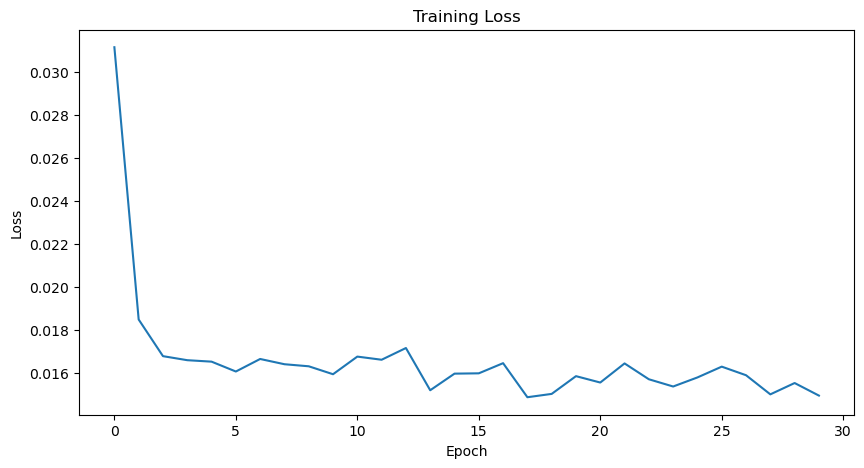

In [11]:
# 绘制 loss 的变化
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [12]:
def generate_by_samples(model, device, samples, n_steps=10):
    """在两个已知样本之间的潜在空间进行插值生成
    """
    model.eval()
    with torch.no_grad():
        generated = model(samples.to(device)).cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(generated[:, 0], generated[:, 1], s=1, alpha=0.5)
    plt.title(f'Generated Samples')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

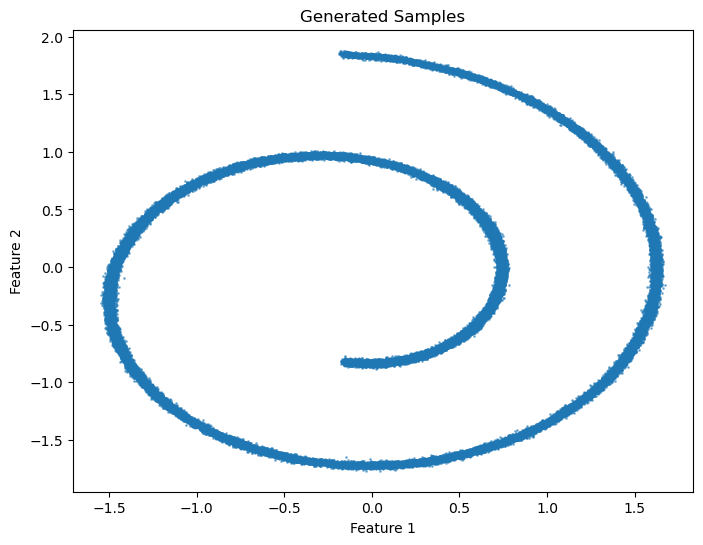

In [13]:
# 存在的问题, 无法通过随机采样来生成, 需要根据数据集中进行 sample
generate_by_samples(model, device, X)